## Configuration

In [2]:
# Autoencoders
from lib.models.autoencoders.autoencoder import AutoencoderDetector
from lib.models.autoencoders.autoencoder_enhanced import AutoencoderDetectorEnhanced
from lib.models.autoencoders.flexible_autoencoder import FlexibleAutoencoder
from lib.models.autoencoders.latent_anomaly_detector import LatentAnomalyDetector
from lib.models.autoencoders.autoencoder_feature_residual_regressor import AutoencoderFeatureResidualRegressor

# Regressors
from lib.models.regressors.residual_regressor import ResidualRegressor

# Evaluation
from lib.evaluation.residual_diagnostics import ResidualDiagnostics
from lib.evaluation.ModelComparisonAnalyzer import ModelComparisonAnalyzer
from lib.evaluation.model_evaluator import evaluate_models

# Visualization
from lib.visualization.feature_residual_viewer import display_feature_residual_timeline_viewer
from lib.visualization.autoencoder_viewers import display_autoencoder_reconstruction, display_autoencoder_with_fault_selection
from lib.visualization.results_visualizer import DetectionResultsVisualizer, display_residual_viewer

# Data
from lib.data.data_generator import generate_synthetic_datasets, load_datasets

# External libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Dict, List, Literal, Optional, Tuple
from pathlib import Path
import pandas as pd

from numpy.typing import NDArray

In [3]:
TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
COLUMNS_TO_REMOVE = [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]

FAULT_INJECTION_POINT = 160

# Toggle between 'real' (load RData files) and 'synthetic' (lightweight random data)
DATA_SOURCE: Literal["real", "synthetic"] = "synthetic"

SYNTHETIC_DATA_CONFIG: Dict[str, Any] = {
    "n_simulation_runs": 5,
    "n_faults": 5,
    "n_samples": 300,
    "n_features": 52,
    "random_state": 42,
    "feature_prefix": "feature",
}

# Load datasets using the extracted function
datasets = load_datasets(DATA_SOURCE, synthetic_config=SYNTHETIC_DATA_CONFIG)

DF_FF_TRAINING_RAW = datasets["fault_free_training"]
DF_FF_TEST_RAW = datasets["fault_free_testing"]
DF_F_TRAINING_RAW = datasets["faulty_training"]
DF_F_TEST_RAW = datasets["faulty_testing"]

print(f"Data source: {DATA_SOURCE}")

Data source: synthetic


In [4]:
# In-control X training data

scaler = StandardScaler()
X_INCONTROL_TRAIN_FULL_DF = DF_FF_TRAINING_RAW.drop(columns=COLUMNS_TO_REMOVE, axis=1)

scaler.fit(X_INCONTROL_TRAIN_FULL_DF)
X_INCONTROL_TRAIN_FULL_SCALED = scaler.transform(X_INCONTROL_TRAIN_FULL_DF)
print("In-control training data shape:", X_INCONTROL_TRAIN_FULL_SCALED.shape)

In-control training data shape: (1500, 52)


In [5]:
simulation_run = 1
fault_number = 2

DF_FF_TRAINING = DF_FF_TRAINING_RAW.query("simulationRun == @simulation_run")
DF_FF_TEST = DF_FF_TEST_RAW.query("simulationRun == @simulation_run")

DF_F_TRAINING = DF_F_TRAINING_RAW.query("faultNumber == @fault_number and simulationRun == @simulation_run")
DF_F_TEST = DF_F_TEST_RAW.query("faultNumber == @fault_number and simulationRun == @simulation_run")


# In-control test data
#scaler = StandardScaler()
X_INCONTROL_TRAIN_REDUCED_DF = DF_FF_TRAINING.drop(columns=COLUMNS_TO_REMOVE, axis=1)
X_INCONTROL_TEST_REDUCED_DF = DF_FF_TEST.drop(columns=COLUMNS_TO_REMOVE, axis=1)

X_INCONTROL_TRAIN_REDUCED_SCALED = scaler.transform(X_INCONTROL_TRAIN_REDUCED_DF)
X_INCONTROL_TEST_REDUCED_SCALED = scaler.transform(X_INCONTROL_TEST_REDUCED_DF)

# Out-of-control test data
X_OUT_OF_CONTROL_TEST_REDUCED_DF = DF_F_TEST.drop(columns=COLUMNS_TO_REMOVE, axis=1)
X_OUT_OF_CONTROL_TRAIN_REDUCED_DF = DF_F_TRAINING.drop(columns=COLUMNS_TO_REMOVE, axis=1)

X_OUT_OF_CONTROL_TEST_REDUCED_SCALED = scaler.transform(X_OUT_OF_CONTROL_TEST_REDUCED_DF)
X_OUT_OF_CONTROL_TRAIN_REDUCED_SCALED = scaler.transform(X_OUT_OF_CONTROL_TRAIN_REDUCED_DF)

print("In-control training data shape:", X_INCONTROL_TRAIN_REDUCED_SCALED.shape)
print("In-control test data shape:", X_INCONTROL_TEST_REDUCED_SCALED.shape)
print("Out-of-control training data shape:", X_OUT_OF_CONTROL_TRAIN_REDUCED_SCALED.shape)
print("Out-of-control test data shape:", X_OUT_OF_CONTROL_TEST_REDUCED_SCALED.shape)


In-control training data shape: (300, 52)
In-control test data shape: (300, 52)
Out-of-control training data shape: (300, 52)
Out-of-control test data shape: (300, 52)


In [6]:
X_INCONTROL_TEST_REDUCED_SCALED_CUT = X_INCONTROL_TEST_REDUCED_SCALED[FAULT_INJECTION_POINT:]
X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT = X_OUT_OF_CONTROL_TEST_REDUCED_SCALED[FAULT_INJECTION_POINT:]

In [7]:
# Combined sequences blending faulty and normal segments for residual experiments
COMBINED_SEGMENT_PERCENT = 0.2  # 20% of each sequence per alternating block

n_samples_cut = len(X_INCONTROL_TEST_REDUCED_SCALED_CUT)
segment_length = max(1, int(COMBINED_SEGMENT_PERCENT * n_samples_cut))

# Helper to split array into segments of equal length (last segment may be shorter)
def split_into_segments(data: np.ndarray) -> list[np.ndarray]:
    return [data[i : i + segment_length] for i in range(0, len(data), segment_length)]

normal_segments = split_into_segments(X_INCONTROL_TEST_REDUCED_SCALED_CUT)
faulty_segments = split_into_segments(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)

# Interleave normal and faulty segments (starting with normal)
combined_segments_normal_first = []
combined_labels_normal_first = []
for normal_seg, faulty_seg in zip(normal_segments, faulty_segments):
    combined_segments_normal_first.append(normal_seg)
    combined_labels_normal_first.append(np.zeros(len(normal_seg), dtype=int))
    combined_segments_normal_first.append(faulty_seg)
    combined_labels_normal_first.append(np.ones(len(faulty_seg), dtype=int))

COMBINED_NORMAL_FAULT_CHAIN = np.concatenate(combined_segments_normal_first, axis=0)
COMBINED_NORMAL_FAULT_LABELS = np.concatenate(combined_labels_normal_first, axis=0)

# Interleave faulty and normal segments (starting with faulty)
combined_segments_fault_first = []
combined_labels_fault_first = []
for faulty_seg, normal_seg in zip(faulty_segments, normal_segments):
    combined_segments_fault_first.append(faulty_seg)
    combined_labels_fault_first.append(np.ones(len(faulty_seg), dtype=int))
    combined_segments_fault_first.append(normal_seg)
    combined_labels_fault_first.append(np.zeros(len(normal_seg), dtype=int))

COMBINED_FAULT_NORMAL_CHAIN = np.concatenate(combined_segments_fault_first, axis=0)
COMBINED_FAULT_NORMAL_LABELS = np.concatenate(combined_labels_fault_first, axis=0)

print("Combined chains prepared:")
print("NORMAL -> FAULT chain shape:", COMBINED_NORMAL_FAULT_CHAIN.shape)
print("FAULT -> NORMAL chain shape:", COMBINED_FAULT_NORMAL_CHAIN.shape)


Combined chains prepared:
NORMAL -> FAULT chain shape: (280, 52)
FAULT -> NORMAL chain shape: (280, 52)


## Autoencoder

In [ ]:
# Basic Autoencoder with Grid Search and Caching

# Define a small parameter grid for experimentation
CUSTOM_PARAM_GRID = {
    "encoding_dim": [8, 16],           # Try 2 encoding dimensions
    "hidden_dim": [16, 32],            # Try 2 hidden layer sizes
    "learning_rate": [0.001, 0.0005],  # Try 2 learning rates
    "batch_size": [32],                # Fix batch size
    "epochs": [50],                    # Fix epochs
    "patience": [10],                  # Fix patience
    "threshold_percentile": [95],      # Fix threshold
}
# This gives us 2 × 2 × 2 × 1 × 1 × 1 × 1 = 8 configurations to test

# Initialize with verbose=1 to see progress
autoencoder_detector = AutoencoderDetector(
    model_dir=Path("trained_models/autoencoder_basic"),
    cache_prefix="autoencoder_basic",
    verbose=1  # Shows progress messages
)

# First run: Will perform grid search and save results
# Subsequent runs: Will load from cache instantly
autoencoder_detector.fit(
    X_INCONTROL_TRAIN_FULL_SCALED,
    param_grid=CUSTOM_PARAM_GRID,     # Use custom grid (or None for default)
    reset_experiment=False,           # Set to True to force retrain
)

print("\n" + "="*80)
print("TRAINING RESULTS")
print("="*80)
print(f"Best config: {autoencoder_detector.best_config}")
print(f"Best metrics: {autoencoder_detector.best_metrics}")
print(f"Threshold: {autoencoder_detector.threshold:.6f}")

# Test predictions
autoencoder_predictions_anomaly = autoencoder_detector.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)
autoencoder_predictions_normal = autoencoder_detector.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT)

arl0 = np.argmax(autoencoder_predictions_normal == 1) if np.any(autoencoder_predictions_normal == 1) else None
arl1 = np.argmax(autoencoder_predictions_anomaly == 1) if np.any(autoencoder_predictions_anomaly == 1) else None

print(f"\nARL0 autoencoder_detector (In-control): {arl0}")
print(f"ARL1 autoencoder_detector (Out-of-control): {arl1}")

# The trained model and config are saved to:
# - models/autoencoder_basic_config.json
# - models/autoencoder_basic_model.keras
# - models/autoencoder_basic_metrics.json
# - models/autoencoder_basic_threshold.json

In [ ]:
# Autoencoder detector reconstruction analysis with fault selection
if autoencoder_detector.model is None:
    print("autoencoder_detector has not been trained yet.")
else:
    FAULT_DATA_RAW = {
        "Fault-free test": DF_FF_TEST_RAW,
        "Faulty test": DF_F_TEST_RAW,
    }

    feature_labels = [f"f{i}" for i in range(X_INCONTROL_TRAIN_FULL_SCALED.shape[1])]
    detector_predict_fn = lambda X: autoencoder_detector.model.predict(X, verbose=0)

    # NEW: Using the clearer function name
    display_autoencoder_with_fault_selection(
        predict_fn=detector_predict_fn,
        raw_dataframes=FAULT_DATA_RAW,          # Clearer name!
        scaler=scaler,
        fault_column=TARGET_VARIABLE_COLUMN_NAME,
        simulation_column=SIMULATION_RUN_COLUMN_NAME,
        metadata_columns=COLUMNS_TO_REMOVE,     # Clearer name!
        default_dataset="Faulty test",          # Clearer name!
        default_fault=2,
        default_simulation=1,
        feature_names=feature_labels,
        viewer_key="autoencoder_basic_viewer",
    )

## autoencoder_detector_enhanced

In [ ]:
# Enhanced Autoencoder with Grid Search and Caching

# Optionally define a smaller parameter grid for faster experimentation
# Leave as None to use the default grid (which has ~200 combinations)
CUSTOM_PARAM_GRID = {
    "encoding_dim": [8, 16],           # Try 2 encoding dimensions
    "noise_stddev": [0.1],             # Fix noise level
    "dropout_rate": [0.2],             # Fix dropout
    "learning_rate": [0.001, 0.0005],  # Try 2 learning rates
    "batch_size": [32],                # Fix batch size
    "epochs": [50],                    # Fix epochs
    "patience": [10],                  # Fix patience
    "threshold_percentile": [95],      # Fix threshold
}
# This gives us 2 × 1 × 1 × 2 × 1 × 1 × 1 × 1 = 4 configurations to test

# Initialize with verbose=1 to see progress
autoencoder_detector_enhanced = AutoencoderDetectorEnhanced(
    model_dir=Path("trained_models/autoencoder_enhanced"),
    cache_prefix="autoencoder_enhanced",
    verbose=1  # Shows progress messages
)

# First run: Will perform grid search and save results
# Subsequent runs: Will load from cache instantly
autoencoder_detector_enhanced.fit(
    X_INCONTROL_TRAIN_FULL_SCALED,
    param_grid=CUSTOM_PARAM_GRID,     # Use custom grid (or None for default)
    reset_experiment=False,           # Set to True to force retrain
)

print("\n" + "="*80)
print("TRAINING RESULTS")
print("="*80)
print(f"Best config: {autoencoder_detector_enhanced.best_config}")
print(f"Best metrics: {autoencoder_detector_enhanced.best_metrics}")
print(f"Threshold: {autoencoder_detector_enhanced.threshold:.6f}")

# Test predictions
autoencoder_predictions_anomaly = autoencoder_detector_enhanced.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)
autoencoder_predictions_normal = autoencoder_detector_enhanced.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT)

arl0 = np.argmax(autoencoder_predictions_normal == 1) if np.any(autoencoder_predictions_normal == 1) else None
arl1 = np.argmax(autoencoder_predictions_anomaly == 1) if np.any(autoencoder_predictions_anomaly == 1) else None

print(f"\nARL0 autoencoder_detector_enhanced (In-control): {arl0}")
print(f"ARL1 autoencoder_detector_enhanced (Out-of-control): {arl1}")

# The trained model and config are saved to:
# - models/autoencoder_enhanced_config.json
# - models/autoencoder_enhanced_model.keras
# - models/autoencoder_enhanced_metrics.json
# - models/autoencoder_enhanced_scaler.json

In [ ]:
# Autoencoder Enhanced detector reconstruction analysis with fault selection
if autoencoder_detector_enhanced.model is None:
    print("autoencoder_detector_enhanced has not been trained yet.")
else:
    # Use the new fault selection mode with raw data
    FAULT_DATA_RAW = {
        "Fault-free test": DF_FF_TEST_RAW,
        "Faulty test": DF_F_TEST_RAW,
    }

    feature_labels = [f"f{i}" for i in range(X_INCONTROL_TRAIN_FULL_SCALED.shape[1])]
    # Use .model.predict() to get reconstructions, not .predict() which returns binary predictions
    detector_predict_fn = lambda X: autoencoder_detector_enhanced.model.predict(X, verbose=0)

    # NEW: Using the clearer function name
    display_autoencoder_with_fault_selection(
        predict_fn=detector_predict_fn,
        raw_dataframes=FAULT_DATA_RAW,
        scaler=scaler,
        fault_column=TARGET_VARIABLE_COLUMN_NAME,
        simulation_column=SIMULATION_RUN_COLUMN_NAME,
        metadata_columns=COLUMNS_TO_REMOVE,
        default_dataset="Faulty test",
        default_fault=2,
        default_simulation=1,
        feature_names=feature_labels,
        viewer_key="autoencoder_enhanced_viewer",
    )

In [ ]:
detector_predict_fn = lambda X: autoencoder_detector_enhanced.model.predict(X, verbose=0)
AE_DATASETS = {
    "Train (full)": X_INCONTROL_TRAIN_FULL_SCALED,
    "Validation (full)": X_INCONTROL_TEST_REDUCED_SCALED,
    "In-control cut": X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    "Out-of-control cut": X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
}

# NEW: Using the clearer function name for simple reconstruction viewing
display_autoencoder_reconstruction(
    predict_fn=detector_predict_fn,
    datasets=AE_DATASETS,
    default_key="In-control cut",
    feature_names=feature_labels,
)

## Flexible Autoencoder


### Optimal Autocoder

In [ ]:
# Train autoencoder teacher using FlexibleAutoencoder
RESET_AUTOENCODER = False

X_residual_train, X_residual_val = train_test_split(
    X_INCONTROL_TRAIN_FULL_SCALED,
    test_size=0.2,
    random_state=42,
    shuffle=False,
)

# Initialize FlexibleAutoencoder
autoencoder = FlexibleAutoencoder(
    verbose=1,
    cache_prefix="flexible_autoencoder"
)

# Generate bottleneck grid
input_dim = X_residual_train.shape[1]
print(f"Input dimensions: {input_dim}")

bottleneck_grid = autoencoder.generate_bottleneck_grid(
    input_dim=input_dim,
    min_ratio=8.0,
    max_ratio=4.0,
)

CUSTOM_AE_GRID = {
    "latent_dim": bottleneck_grid["latent_dim"],
    "encoder_layers": [(256, 128)],
    "activation": ["relu"],
    "learning_rate": [1e-3],
    "batch_size": [256],
    "epochs": [120],
    "patience": [15],
}

print(f"\nBottleneck sizes: {CUSTOM_AE_GRID['latent_dim']}")

# Train
autoencoder.fit(
    X_residual_train,
    X_residual_val,
    # param_grid=CUSTOM_AE_GRID,
    reset=RESET_AUTOENCODER,
)

# Display summary with elbow curve and residual distribution
autoencoder.plot_summary(X_residual_train, X_residual_val)


In [ ]:
AE_DATASETS = {
    "Train (full)": X_INCONTROL_TRAIN_FULL_SCALED,
    "Validation (full)": X_INCONTROL_TEST_REDUCED_SCALED,
    "In-control cut": X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    "Out-of-control cut": X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
}

feature_labels = [f"f{i}" for i in range(X_INCONTROL_TRAIN_FULL_SCALED.shape[1])]

# Use autoencoder.predict() for reconstructions
predict_fn = lambda X: autoencoder.predict(X)

display_autoencoder_reconstruction(
    predict_fn=predict_fn,
    datasets=AE_DATASETS,
    default_key="In-control cut",
    feature_names=feature_labels,
)

### Overfittet Autocoder

[Grid Search] Testing config: {'latent_dim': 64, 'encoder_layers': (512, 256, 128), 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 150, 'patience': 25}
[Training] Config: {'latent_dim': 64, 'encoder_layers': (512, 256, 128), 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 150, 'patience': 25}
[Grid Search] val_loss=0.145253
[Grid Search] Best config: {'latent_dim': 64, 'encoder_layers': (512, 256, 128), 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 150, 'patience': 25}
[Grid Search] Best val_loss: 0.145253


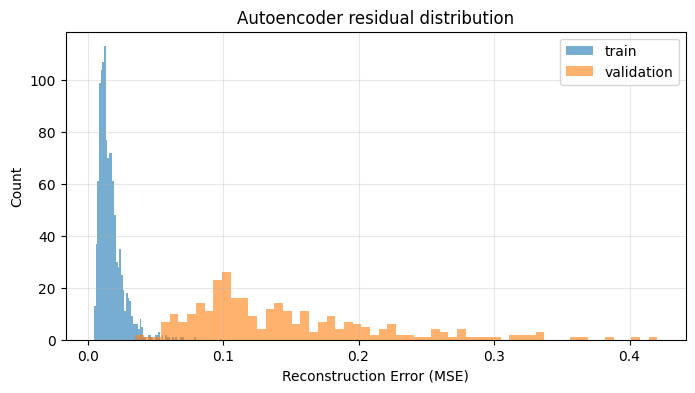


Reconstruction Error Statistics:
  Train: mean=0.0168, std=0.0091
  Val:   mean=0.1453, std=0.0714


In [ ]:
# Train overfitted autoencoder with large latent dimension
RESET_OVERFITTED_AUTOENCODER = False

X_residual_train, X_residual_val = train_test_split(
    X_INCONTROL_TRAIN_FULL_SCALED,
    test_size=0.2,
    random_state=42,
    shuffle=False,
)

autoencoder_overfitted = FlexibleAutoencoder(
    verbose=1,
    cache_prefix="autoencoder_overfitted"
)


OVERFITTED_AE_GRID = {
    "latent_dim": [64],
    "encoder_layers": [(512, 256, 128)],
    "activation": ["relu"],
    "learning_rate": [1e-3],
    "batch_size": [256],
    "epochs": [150],
    "patience": [25],
}

autoencoder_overfitted.fit(
    X_residual_train,
    X_residual_val,
    param_grid=OVERFITTED_AE_GRID,
    reset=RESET_OVERFITTED_AUTOENCODER,
)

# Display summary with elbow curve and residual distribution

autoencoder_overfitted.plot_residual_distribution(X_residual_train, X_residual_val)

"""This plot shows how big the reconstruction error is for each sample, for train vs validation.

X‑axis (Reconstruction Error MSE): per‑sample mean‑squared error between input and reconstruction.

Left (near 0) = the autoencoder reconstructs very well.
Right (e.g. >0.2, >0.5) = poor reconstruction.
Y‑axis (Count): how many samples fall into each error bin.

Blue (“train”): error distribution on the training data.

Orange (“validation”): error distribution on the validation data.

How to interpret:

If both histograms are clustered near 0 and overlap strongly, the model reconstructs both train and val well and generalizes similarly.
If train is much further left (smaller errors) and validation is shifted right, the model is overfitting: it memorizes train better than unseen data.
Very long right tails (few samples with high error) indicate potential outliers/anomalies—those points are reconstructed badly."""

In [20]:
AE_DATASETS = {
    "Train (full)": X_INCONTROL_TRAIN_FULL_SCALED,
    "Validation (full)": X_INCONTROL_TEST_REDUCED_SCALED,
    "In-control cut": X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    "Out-of-control cut": X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
}

feature_labels = [f"f{i}" for i in range(X_INCONTROL_TRAIN_FULL_SCALED.shape[1])]

predict_fn = lambda X: autoencoder_overfitted.predict(X)

display_autoencoder_reconstruction(
    predict_fn=predict_fn,
    datasets=AE_DATASETS,
    default_key="In-control cut",
    feature_names=feature_labels,
)


NameError: name 'autoencoder_overfitted' is not defined

### Custom Autoencoder

In [9]:
autoencoder_custom = FlexibleAutoencoder(
    verbose=1,
    cache_prefix="autoencoder_custom"
)


X_residual_train, X_residual_val = train_test_split(
    X_INCONTROL_TRAIN_FULL_SCALED,
    test_size=0.2,
    random_state=42,
    shuffle=False,
)

input_dim = X_residual_train.shape[1]

print(f"Input dimensions: {input_dim}")

Input dimensions: 52


[Training] Config: {'encoder_layers': (50, 48, 44, 40, 36, 32), 'latent_dim': 28, 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 1000, 'patience': 1000}


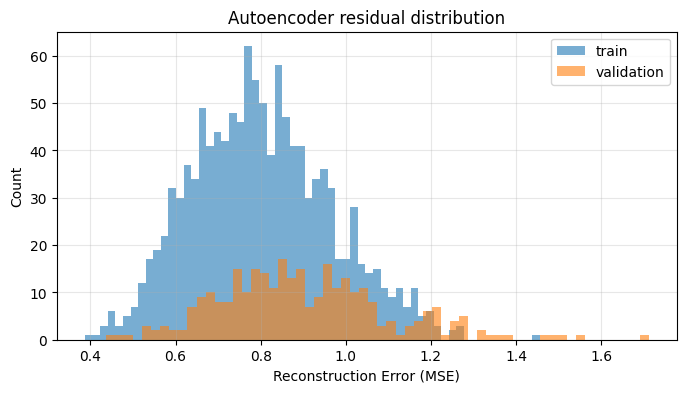


Reconstruction Error Statistics:
  Train: mean=0.8027, std=0.1634
  Val:   mean=0.9027, std=0.2010


In [ ]:
RESET_AUTOENCODER = True
activation = "relu"
#activation = "linear"

"""the encoder will be:
input_dim → 50 → 48 → 44 → 40 → 36 → 32 → 28 (latent_dim)
and the decoder will mirror it:
28 → 32 → 36 → 40 → 44 → 48 → 50 → output_dim."""

CUSTOM_AE_CONFIG = {
    "encoder_layers": [50,48,44,40,36,32],
    "latent_dim": 28,
    "activation": activation,
    "learning_rate": 0.001,
    "batch_size": 256,
    "epochs": 1000,
    "patience": 1000,
}

autoencoder_custom.fit(
    X_residual_train,
    X_residual_val,
    config=CUSTOM_AE_CONFIG,
    reset=RESET_AUTOENCODER,
)

# Display summary with elbow curve and residual distribution

autoencoder_custom.plot_residual_distribution(X_residual_train, X_residual_val)


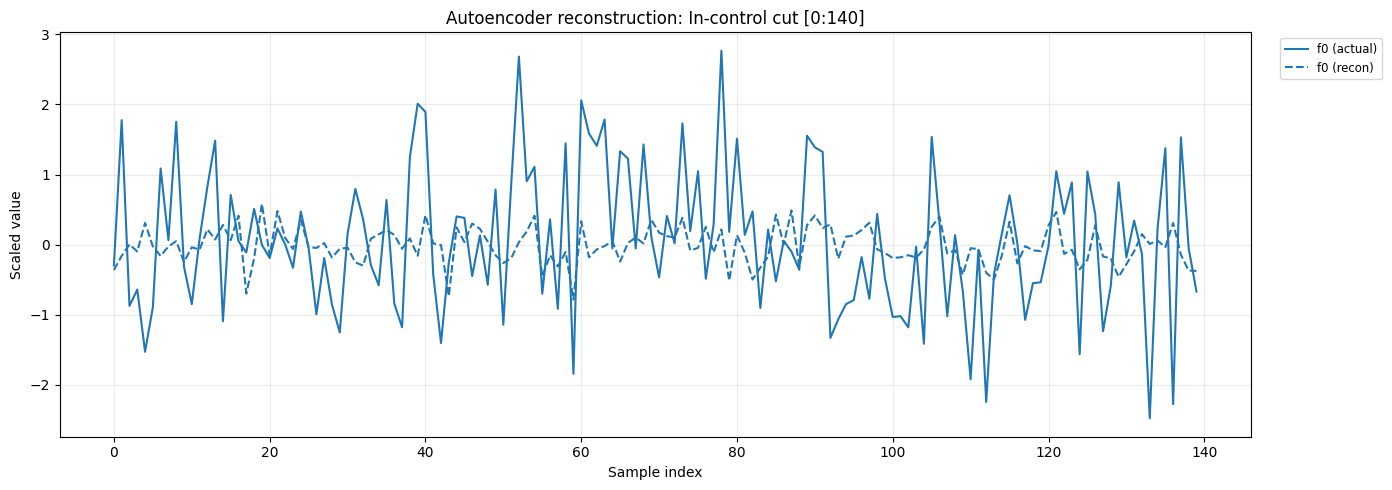

In [32]:
AE_DATASETS = {
    "Train (full)": X_INCONTROL_TRAIN_FULL_SCALED,
    "Validation (full)": X_INCONTROL_TEST_REDUCED_SCALED,
    "In-control cut": X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    "Out-of-control cut": X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
}

feature_labels = [f"f{i}" for i in range(X_INCONTROL_TRAIN_FULL_SCALED.shape[1])]

predict_fn = lambda X: autoencoder_custom.predict(X)

display_autoencoder_reconstruction(
    predict_fn=predict_fn,
    datasets=AE_DATASETS,
    default_key="In-control cut",
    feature_names=feature_labels,
)


## Latent Anomaly Detector

Deep neural network that detects anomalies in the latent space using supervised learning.

In [ ]:
# Prepare labeled data for supervised learning
# Use COMBINED chains that alternate between normal and fault
# X data: raw features (will be encoded internally by the detector)
# y labels: 0 = normal, 1 = anomaly

# Split combined chains for training/validation
X_latent_train = COMBINED_NORMAL_FAULT_CHAIN[:int(len(COMBINED_NORMAL_FAULT_CHAIN) * 0.8)]
y_latent_train = COMBINED_NORMAL_FAULT_LABELS[:int(len(COMBINED_NORMAL_FAULT_LABELS) * 0.8)]

X_latent_val = COMBINED_NORMAL_FAULT_CHAIN[int(len(COMBINED_NORMAL_FAULT_CHAIN) * 0.8):]
y_latent_val = COMBINED_NORMAL_FAULT_LABELS[int(len(COMBINED_NORMAL_FAULT_LABELS) * 0.8):]

print(f"Training set: {X_latent_train.shape}, Normal: {(y_latent_train == 0).sum()}, Anomaly: {(y_latent_train == 1).sum()}")
print(f"Validation set: {X_latent_val.shape}, Normal: {(y_latent_val == 0).sum()}, Anomaly: {(y_latent_val == 1).sum()}")

In [ ]:
# Train Latent Anomaly Detector with grid search
RESET_LATENT_DETECTOR = True
LATENT_DETECTOR_PARAM_GRID = None  # Use default grid

# Get encoder from the trained autoencoder
encoder = autoencoder.get_encoder()

# Create latent anomaly detector
latent_detector = LatentAnomalyDetector(
    encoder=encoder,
    verbose=1,
    cache_prefix="latent_anomaly_detector"
)

# Train with grid search
latent_detector.fit(
    X_latent_train,
    y_latent_train,
    X_latent_val,
    y_latent_val,
    param_grid=LATENT_DETECTOR_PARAM_GRID,
    reset=RESET_LATENT_DETECTOR
)

print("\n" + "="*80)
print("TRAINING RESULTS")
print("="*80)
print(f"Best config: {latent_detector.config}")
print(f"Metrics: {latent_detector.metrics}")

In [ ]:
# Visualize training results
latent_detector.plot_summary(
    X_latent_train,
    y_latent_train,
    X_latent_val,
    y_latent_val,
    threshold=0.5
)

In [ ]:
# Test the detector on cut data
LATENT_DETECTOR_THRESHOLD = 0.9

# Wrapper function for model comparison
def latent_anomaly_detector_predict(X: np.ndarray) -> np.ndarray:
    return latent_detector.predict(X, threshold=LATENT_DETECTOR_THRESHOLD)

# Get predictions on test data
latent_predictions_normal = latent_detector.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT, threshold=LATENT_DETECTOR_THRESHOLD)
latent_predictions_anomaly = latent_detector.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT, threshold=LATENT_DETECTOR_THRESHOLD)

# Get anomaly scores
latent_scores_normal = latent_detector.predict_proba(X_INCONTROL_TEST_REDUCED_SCALED_CUT)
latent_scores_anomaly = latent_detector.predict_proba(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)

# Calculate ARL metrics
arl0_latent = np.argmax(latent_predictions_normal == 1) if np.any(latent_predictions_normal == 1) else None
arl1_latent = np.argmax(latent_predictions_anomaly == 1) if np.any(latent_predictions_anomaly == 1) else None

print(f"\nLatent Anomaly Detector Results (threshold={LATENT_DETECTOR_THRESHOLD}):")
print(f"  ARL0 (In-control): {arl0_latent}")
print(f"  ARL1 (Out-of-control): {arl1_latent}")
print(f"\nAnomaly Score Statistics:")
print(f"  Normal: mean={latent_scores_normal.mean():.4f}, std={latent_scores_normal.std():.4f}")
print(f"  Anomaly: mean={latent_scores_anomaly.mean():.4f}, std={latent_scores_anomaly.std():.4f}")

### Test Encoder: Extract Latent Vectors

In [ ]:
# Test encoder: Extract latent vectors from raw features
# This demonstrates the encoder transformation: Raw Features → Latent Space

# Get encoder from autoencoder
test_encoder = autoencoder.get_encoder()

# Take a few test samples
test_samples = X_INCONTROL_TEST_REDUCED_SCALED_CUT[:5]  # First 5 samples

print("=" * 80)
print("ENCODER TEST: Raw Features → Latent Vectors")
print("=" * 80)

# Method 1: Use autoencoder.encode() (recommended)
latent_vectors_method1 = autoencoder.encode(test_samples)

# Method 2: Use encoder.predict() directly
latent_vectors_method2 = test_encoder.predict(test_samples, verbose=0)

# Method 3: Through latent_detector (uses frozen encoder)
latent_vectors_method3 = latent_detector.get_latent(test_samples)

print(f"\nOriginal feature shape: {test_samples.shape}")
print(f"  → Input dimension: {test_samples.shape[1]} features")

print(f"\nLatent vector shape: {latent_vectors_method1.shape}")
print(f"  → Latent dimension: {latent_vectors_method1.shape[1]} features")
print(f"  → Compression ratio: {test_samples.shape[1] / latent_vectors_method1.shape[1]:.2f}x")

print(f"\n✓ All three methods produce identical results: {np.allclose(latent_vectors_method1, latent_vectors_method2) and np.allclose(latent_vectors_method1, latent_vectors_method3)}")

print("\n" + "-" * 80)
print("Sample Latent Vector (first sample, first 10 dimensions):")
print("-" * 80)
print(latent_vectors_method1[0, :10])

print("\n" + "-" * 80)
print("Latent Vector Statistics:")
print("-" * 80)
print(f"  Mean: {latent_vectors_method1.mean():.4f}")
print(f"  Std:  {latent_vectors_method1.std():.4f}")
print(f"  Min:  {latent_vectors_method1.min():.4f}")
print(f"  Max:  {latent_vectors_method1.max():.4f}")

### Test Decoder: Verify Encoder → Decoder = Autoencoder

In [ ]:
# Test: Verify that Encoder → Decoder produces the same result as Autoencoder
# This confirms that encoder and decoder are correctly extracted and share weights

# Get encoder and decoder from autoencoder
test_encoder = autoencoder.get_encoder()
test_decoder = autoencoder.get_decoder()

# Take test samples
test_samples = X_INCONTROL_TEST_REDUCED_SCALED_CUT[:5]  # First 5 samples

print("=" * 80)
print("DECODER TEST: Verify Encoder → Decoder = Autoencoder")
print("=" * 80)

# ========== Method 1: Use full autoencoder directly ==========
reconstructions_method1 = autoencoder.predict(test_samples)

# ========== Method 2: Use encoder then decoder (manual pipeline) ==========
# Step 1: Encode to latent space
latent_vectors = test_encoder.predict(test_samples, verbose=0)
# Step 2: Decode back to original space
reconstructions_method2 = test_decoder.predict(latent_vectors, verbose=0)

# ========== Method 3: Use encode() and decode() helper methods ==========
latent_via_helper = autoencoder.encode(test_samples)
reconstructions_method3 = autoencoder.decode(latent_via_helper)

print(f"\nOriginal samples shape: {test_samples.shape}")
print(f"Latent vectors shape:   {latent_vectors.shape}")
print(f"Reconstructions shape:  {reconstructions_method1.shape}")

print("\n" + "-" * 80)
print("Verification Results:")
print("-" * 80)

# Check if all three methods produce identical results
method1_vs_method2 = np.allclose(reconstructions_method1, reconstructions_method2, rtol=1e-5, atol=1e-8)
method1_vs_method3 = np.allclose(reconstructions_method1, reconstructions_method3, rtol=1e-5, atol=1e-8)

print(f"✓ Method 1 (autoencoder) == Method 2 (encoder → decoder): {method1_vs_method2}")
print(f"✓ Method 1 (autoencoder) == Method 3 (encode → decode):  {method1_vs_method3}")

if method1_vs_method2 and method1_vs_method3:
    print("\n✅ SUCCESS: All three methods produce IDENTICAL results!")
    print("   This confirms encoder and decoder are correctly extracted.")
else:
    print("\n⚠️  WARNING: Methods produce different results!")
    max_diff = np.max(np.abs(reconstructions_method1 - reconstructions_method2))
    print(f"   Maximum difference: {max_diff}")

# Show reconstruction quality
print("\n" + "-" * 80)
print("Reconstruction Quality:")
print("-" * 80)
reconstruction_errors = np.mean(np.square(test_samples - reconstructions_method1), axis=1)
print(f"  Mean Squared Error per sample: {reconstruction_errors}")
print(f"  Average MSE: {reconstruction_errors.mean():.6f}")

print("\n" + "-" * 80)
print("Data Flow Verification:")
print("-" * 80)
print(f"  Input: {test_samples.shape[1]} features")
print(f"    ↓ Encoder")
print(f"  Latent: {latent_vectors.shape[1]} features (compressed)")
print(f"    ↓ Decoder")
print(f"  Output: {reconstructions_method1.shape[1]} features (reconstructed)")
print(f"\n  Compression ratio: {test_samples.shape[1] / latent_vectors.shape[1]:.2f}x")
print(f"  ✓ Input dimension == Output dimension: {test_samples.shape[1] == reconstructions_method1.shape[1]}")

**⚠️ IMPORTANT:** If the test above shows `False` (methods don't match), you need to **retrain the autoencoder** with the fixed code:

1. Set `RESET_AUTOENCODER = True` in the autoencoder training cell
2. Run the autoencoder training cell to force retrain
3. Run this test again - it should now show `True` (all methods match)

The old cached model had a bug in encoder/decoder extraction that has been fixed.

## Autoencoder Residual Regressor

In [ ]:
# Train residual regressor (student) using trained autoencoder
RESET_TRAINING = False
RESIDUAL_PARAM_GRID = None
RESIDUAL_THRESHOLD_PERCENTILE = 99.5

# Create residual regressor with trained autoencoder
residual_regressor = ResidualRegressor(
    autoencoder=autoencoder.autoencoder,
    verbose=1,
    cache_prefix="residual_regressor"
)

# Train regressor
residual_regressor.fit(
    X_residual_train,
    X_residual_val,
    param_grid=RESIDUAL_PARAM_GRID,
    reset=RESET_TRAINING,
)

train_pred_residuals = residual_regressor.predict(X_residual_train)
train_true_residuals = residual_regressor.autoencoder_residuals(X_residual_train)
val_true_residuals = residual_regressor.autoencoder_residuals(X_residual_val)
val_pred_residuals = residual_regressor.predict(X_residual_val)

residual_metrics_train = residual_regressor.evaluate(X_residual_train, train_true_residuals)
residual_metrics_val = residual_regressor.evaluate(X_residual_val, val_true_residuals)
print("Residual regressor training metrics:", residual_metrics_train)
print("Residual regressor validation metrics:", residual_metrics_val)

residual_threshold = np.percentile(
    train_pred_residuals,
    RESIDUAL_THRESHOLD_PERCENTILE,
)
print(
    f"Residual threshold (percentile {RESIDUAL_THRESHOLD_PERCENTILE}): {residual_threshold:.6f}"
)

# Interactive residual diagnostics
RESIDUAL_DATASETS = {
    "In-control (test-cut)": X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    "Out-of-control (test-cut)": X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
}
display_residual_viewer(
    residual_regressor,
    RESIDUAL_DATASETS,
    threshold=residual_threshold,
    baseline_key="In-control (test-cut)",
    sample_size=5000 if len(X_INCONTROL_TEST_REDUCED_SCALED_CUT) > 5000 else None,
)


In [ ]:
def autoencoder_residual_regressor_predict(X: np.ndarray) -> np.ndarray:
    scores = residual_regressor.predict(X)
    return (scores > residual_threshold).astype(int)

in_control_scores = residual_regressor.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT)
out_of_control_scores = residual_regressor.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)

in_control_flags = (in_control_scores > residual_threshold).astype(int)
out_of_control_flags = (out_of_control_scores > residual_threshold).astype(int)

in_control_ae = residual_regressor.autoencoder_residuals(X_INCONTROL_TEST_REDUCED_SCALED_CUT)
out_of_control_ae = residual_regressor.autoencoder_residuals(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)

print(f"In-control residual flags: {in_control_flags.sum()} / {in_control_flags.size}")
print(f"Out-of-control residual flags: {out_of_control_flags.sum()} / {out_of_control_flags.size}")

first_false_alarm = int(np.argmax(in_control_flags == 1)) if np.any(in_control_flags == 1) else None

## Per-feature residual regressor

In [ ]:

def _agg_residual(mat: np.ndarray, mode: str = "mean") -> np.ndarray:
    if mode == "mean":
        return np.mean(mat, axis=1)
    if mode == "max":
        return np.max(mat, axis=1)
    if mode == "sum":
        return np.sum(mat, axis=1)
    if mode == "median":
        return np.median(mat, axis=1)
    raise ValueError("Unknown aggregation mode; expected mean|max|sum|median")

RESET_FEATURE_RESIDUAL_PIPELINE = False
FEATURE_RESIDUAL_PARAM_GRID = None
FEATURE_AGG = "mean"
FEATURE_RESIDUAL_THRESHOLD_PERCENTILE = 99.5

# Optionally attach a pre-trained AE teacher (baseline or enhanced)
teacher_model = None
teacher_preprocess = None
# Prefer enhanced AE if available
try:
    autoencoder_detector_enhanced
    if getattr(autoencoder_detector_enhanced, 'model', None) is not None:
        teacher_model = autoencoder_detector_enhanced.model
        teacher_preprocess = lambda X: autoencoder_detector_enhanced._normalize(X, fit=False)
        print('[Teacher] Using AutoencoderDetectorEnhanced')
except NameError:
    pass
# Fallback to baseline AE if available
if teacher_model is None:
    try:
        autoencoder_detector
        if getattr(autoencoder_detector, 'model', None) is not None:
            teacher_model = autoencoder_detector.model
            teacher_preprocess = None
            print('[Teacher] Using AutoencoderDetector')
    except NameError:
        pass

feature_residual_regressor = AutoencoderFeatureResidualRegressor(
    verbose=1,
    autoencoder=teacher_model,
    teacher_preprocess=teacher_preprocess,
)
feature_residual_regressor.fit(
    X_residual_train,
    X_residual_val,
    param_grid=FEATURE_RESIDUAL_PARAM_GRID,
    reset_experiment=RESET_FEATURE_RESIDUAL_PIPELINE,
)

# Threshold on aggregated predicted per-feature residuals (computed on train)
train_pred_mat = feature_residual_regressor.predict(X_residual_train)
train_agg = _agg_residual(train_pred_mat, FEATURE_AGG)
feature_residual_threshold = float(np.percentile(train_agg, FEATURE_RESIDUAL_THRESHOLD_PERCENTILE))
print(f"Feature residual threshold ({FEATURE_AGG}, percentile {FEATURE_RESIDUAL_THRESHOLD_PERCENTILE}): {feature_residual_threshold:.6f}")

# --- Teacher AE threshold and wrapper for benchmarking ---
TEACHER_THRESHOLD_PERCENTILE = 99.5
if teacher_model is not None:
    # Prefer enhanced teacher score if the model matches
    try:
        autoencoder_detector_enhanced
        if getattr(autoencoder_detector_enhanced, 'model', None) is teacher_model:
            teacher_scores_train = autoencoder_detector_enhanced.get_anomaly_scores(X_residual_train)
        else:
            raise NameError
    except NameError:
        train_recon = teacher_model.predict(X_residual_train, verbose=0)
        teacher_scores_train = np.mean(np.square(X_residual_train - train_recon), axis=1)
else:
    # Fallback to the internally trained AE if no external teacher attached
    train_recon = feature_residual_regressor.autoencoder.predict(X_residual_train, verbose=0)
    teacher_scores_train = np.mean(np.square(X_residual_train - train_recon), axis=1)

teacher_threshold = float(np.percentile(teacher_scores_train, TEACHER_THRESHOLD_PERCENTILE))
print(f"Teacher threshold (p{TEACHER_THRESHOLD_PERCENTILE}): {teacher_threshold:.6f}")

def ae_teacher_predict(X: np.ndarray) -> np.ndarray:
    try:
        autoencoder_detector_enhanced
        if getattr(autoencoder_detector_enhanced, 'model', None) is teacher_model:
            scores = autoencoder_detector_enhanced.get_anomaly_scores(X)
        else:
            raise NameError
    except NameError:
        recon = (teacher_model or feature_residual_regressor.autoencoder).predict(X, verbose=0)
        scores = np.mean(np.square(X - recon), axis=1)
    return (scores > teacher_threshold).astype(int)



In [ ]:
# Diagnostics: scatter and timeline (aggregated)
feature_residual_regressor.plot_residual_fit(
    X_residual_val,
    sample_size=5000 if len(X_residual_val) > 5000 else None,
)
feature_residual_regressor.plot_residual_series(
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
    agg=FEATURE_AGG,
    title="Out-of-control aggregated residual timeline (cut)",
)

def autoencoder_feature_residual_regressor_predict(X: np.ndarray) -> np.ndarray:
    mat = feature_residual_regressor.predict(X)
    agg = _agg_residual(mat, FEATURE_AGG)
    return (agg > feature_residual_threshold).astype(int)
first_detection = int(np.argmax(out_of_control_flags == 1)) if np.any(out_of_control_flags == 1) else None
print(f"First false alarm index: {first_false_alarm}")
print(f"First detection index: {first_detection}")

AUTOENCODER_RESIDUAL_THRESHOLD = residual_threshold

ResidualDiagnostics.timeline(
    in_control_scores,
    true_residuals=in_control_ae,
    threshold=residual_threshold,
    title="In-control residual timeline (cut)",
)

ResidualDiagnostics.timeline(
    out_of_control_scores,
    true_residuals=out_of_control_ae,
    threshold=residual_threshold,
    title="Out-of-control residual timeline (cut)",
)

In [ ]:
# Interactive per-feature residual timeline viewer (AE vs regressor)
FEATURE_DATASETS = {
    "In-control (test-cut)": X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    "Out-of-control (test-cut)": X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
}
feature_names = [f"f{i}" for i in range(X_INCONTROL_TRAIN_FULL_SCALED.shape[1])]
display_feature_residual_timeline_viewer(
    feature_residual_regressor,
    FEATURE_DATASETS,
    feature_names=feature_names,
    default_key="In-control (test-cut)",
    default_feature=0,
    sample_size=4000 if len(X_INCONTROL_TEST_REDUCED_SCALED_CUT) > 4000 else None,
    random_state=42,
)


## Run with all samples

In [ ]:
# Define models dictionary (Autoencoder-based only)
MODELS = {
    "AE_Teacher": ae_teacher_predict,
    "AE_ResidualRegressor": autoencoder_residual_regressor_predict,
    "AE_FeatureResidualRegressor": autoencoder_feature_residual_regressor_predict,
    "LatentAnomalyDetector": latent_anomaly_detector_predict,
    "Autoencoder": autoencoder_detector.predict,
    "AutoencoderEnhanced": autoencoder_detector_enhanced.predict,
}

# Run evaluation using the extracted module
df_results, summary_df = evaluate_models(
    models=MODELS,
    df_ff_test_raw=DF_FF_TEST_RAW,
    df_f_test_raw=DF_F_TEST_RAW,
    scaler=scaler,
    fault_injection_point=FAULT_INJECTION_POINT,
    simulation_column=SIMULATION_RUN_COLUMN_NAME,
    fault_column=TARGET_VARIABLE_COLUMN_NAME,
    columns_to_remove=COLUMNS_TO_REMOVE,
    verbose=True
)

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)
print(f"Results shape: {df_results.shape}")
print(f"Summary shape: {summary_df.shape}")
print(f"Models evaluated: {', '.join(MODELS.keys())}")

In [ ]:
# Initialize the analyzer
analyzer = ModelComparisonAnalyzer(df_results, summary_df)

### Summary Tables & Statistics

In [ ]:
#analyzer.display_summary_tables()

### Model Rankings

### Per-Fault Model Rankings

In [ ]:
#analyzer.display_per_fault_rankings(method='ratio')

In [ ]:
#analyzer.display_model_rankings()

### ARL Analysis (ARL0 & ARL1)

In [ ]:
analyzer.plot_arl_analysis()

### Average ARL Performance

In [ ]:
analyzer.plot_arl_averages()
plt.show()

### Overall Classification Metrics

In [ ]:
analyzer.plot_overall_metrics()

"""This is a bar chart with error bars. Specifically:
- The bars show the mean (average) value of the metric (Precision in this case) for each model
- The error bars (the black lines with caps on top of each bar) show the standard deviation, representing the variability/spread of the data across different simulation runs or faults
- The numbers on top display the exact mean values (0.972, 0.991, 0.862, etc.)"""


"""
Precision: High when the model rarely flags normal data as anomalies (few false alarms)
Recall: High when the model catches most anomalies (few missed detections)
Specificity: High when the model correctly identifies normal data (few false alarms)
Accuracy: High when the model makes few mistakes overall (both false alarms and missed detections are low)
F1 Score: High when the model balances precision and recall well (good at both catching anomalies and avoiding false alarms)
"""

### Per-Fault Classification Metrics (Bar Charts)

In [ ]:
analyzer.plot_per_fault_bars()

### False Positive Rate (FPR) & False Negative Rate (FNR)

**False Rate Metrics:**
- **FPR (False Positive Rate)**: Lower is better - Measures how often the model incorrectly flags normal data as anomalies (like saying fault when it's normal)
- **FNR (False Negative Rate)**: Lower is better - Measures how often the model misses actual anomalies (like saying normal when there's a fault)

In [ ]:
analyzer.plot_false_rates()
plt.show()

### Confusion Matrix Components


In [ ]:
# Average confusion matrix components across all faults
analyzer.plot_confusion_matrix_components_average()
plt.show()

In [ ]:
# Per-fault confusion matrix components
analyzer.plot_confusion_matrix_components_per_fault()
plt.show()

### Confusion Matrix Heatmaps

Standard confusion matrix visualization showing:
- **TN (True Negative)**: Top-left - Correctly identified normal data
- **FP (False Positive)**: Top-right - Incorrectly flagged as anomaly (false alarm)
- **FN (False Negative)**: Bottom-left - Missed anomaly
- **TP (True Positive)**: Bottom-right - Correctly detected anomaly

In [ ]:
# Average confusion matrix heatmaps across all faults
analyzer.plot_confusion_matrix_average()
plt.show()

In [ ]:
# Per-fault confusion matrix heatmaps
analyzer.plot_confusion_matrices_per_fault()
plt.show()

### Per-Fault Classification Metrics (Line Plots)

In [ ]:
analyzer.plot_per_fault_lines()

### Heatmaps

In [ ]:
analyzer.plot_heatmaps()

### Statistical Distributions

In [ ]:
analyzer.plot_distributions()

In [ ]:
# visualizer = DetectionResultsVisualizer(df_results, summary_df)

# summary_table = visualizer.summary_table()
# display(summary_table)

# visualizer.plot_arl_profiles()
# visualizer.plot_detection_fraction()
# visualizer.heatmap('conditional_ARL1', cmap='magma')
# visualizer.bar_false_alarm_rate()
